# Book Recommender

----
## Project Details

Prepared for: CSCA 5632 Unsupervised Algorithms in Machine Learning, University of Colorado Boulder
### Problem
Our primary objective is to recommend books to users based on the similarity of ratings and genres. We'll use unsupervised learning techniques to find latent structures in the data that can help with making recommendations.

For this project we will use a data set from Kaggle (https://www.kaggle.com/datasets/middlelight/goodreadsbookswithgenres) that contains data obtained from the GoodReads API.

This a CSV dataset containing 11,127 records of books with details like "title", "author", "average_rating", and "genre".

To create this recommender, we will attempt to focus on the genre and ratings and utilize a TruncatedSVD model and item-item similarity. With this we should be able to input a book entry and output a collection of similar books.

In [203]:
# Library imports
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

----
## Exploratory Data Analysis

#### Load and inspect the data

In [204]:
file_path = '.\\data\\books_with_genres.csv'
df = pd.read_csv(file_path)

print(df.head())
print(df.info())

   Book Id                                              Title  \
0        1  Harry Potter and the Half-Blood Prince (Harry ...   
1        2  Harry Potter and the Order of the Phoenix (Har...   
2        4  Harry Potter and the Chamber of Secrets (Harry...   
3        5  Harry Potter and the Prisoner of Azkaban (Harr...   
4        8  Harry Potter Boxed Set  Books 1-5 (Harry Potte...   

                       Author  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   
1  J.K. Rowling/Mary GrandPré            4.49  0439358078  9780439358071   
2                J.K. Rowling            4.42  0439554896  9780439554893   
3  J.K. Rowling/Mary GrandPré            4.56  043965548X  9780439655484   
4  J.K. Rowling/Mary GrandPré            4.78  0439682584  9780439682589   

  language_code  num_pages  ratings_count  text_reviews_count  \
0           eng        652        2095690               27591   
1           eng       

#### Clean the data by removing any rows with missing values

In [205]:
missing_values = df.isnull().sum()
print(missing_values)
df = df.dropna()

Book Id                0
Title                  0
Author                 0
average_rating         0
isbn                   0
isbn13                 0
language_code          0
num_pages              0
ratings_count          0
text_reviews_count     0
publication_date       0
publisher              0
genres                97
dtype: int64


#### Transform the genre column by encoding it into binary features

In [206]:
genres = df['genres'].str.get_dummies(sep=';')
encoded_df = pd.concat([df, genres], axis=1)
encoded_df = encoded_df.drop('genres', axis=1)
print(encoded_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11030 entries, 0 to 11126
Columns: 902 entries, Book Id to Young Adult,Young Adult Science Fiction
dtypes: float64(1), int64(895), object(6)
memory usage: 76.0+ MB
None


#### View distribution of numerical features

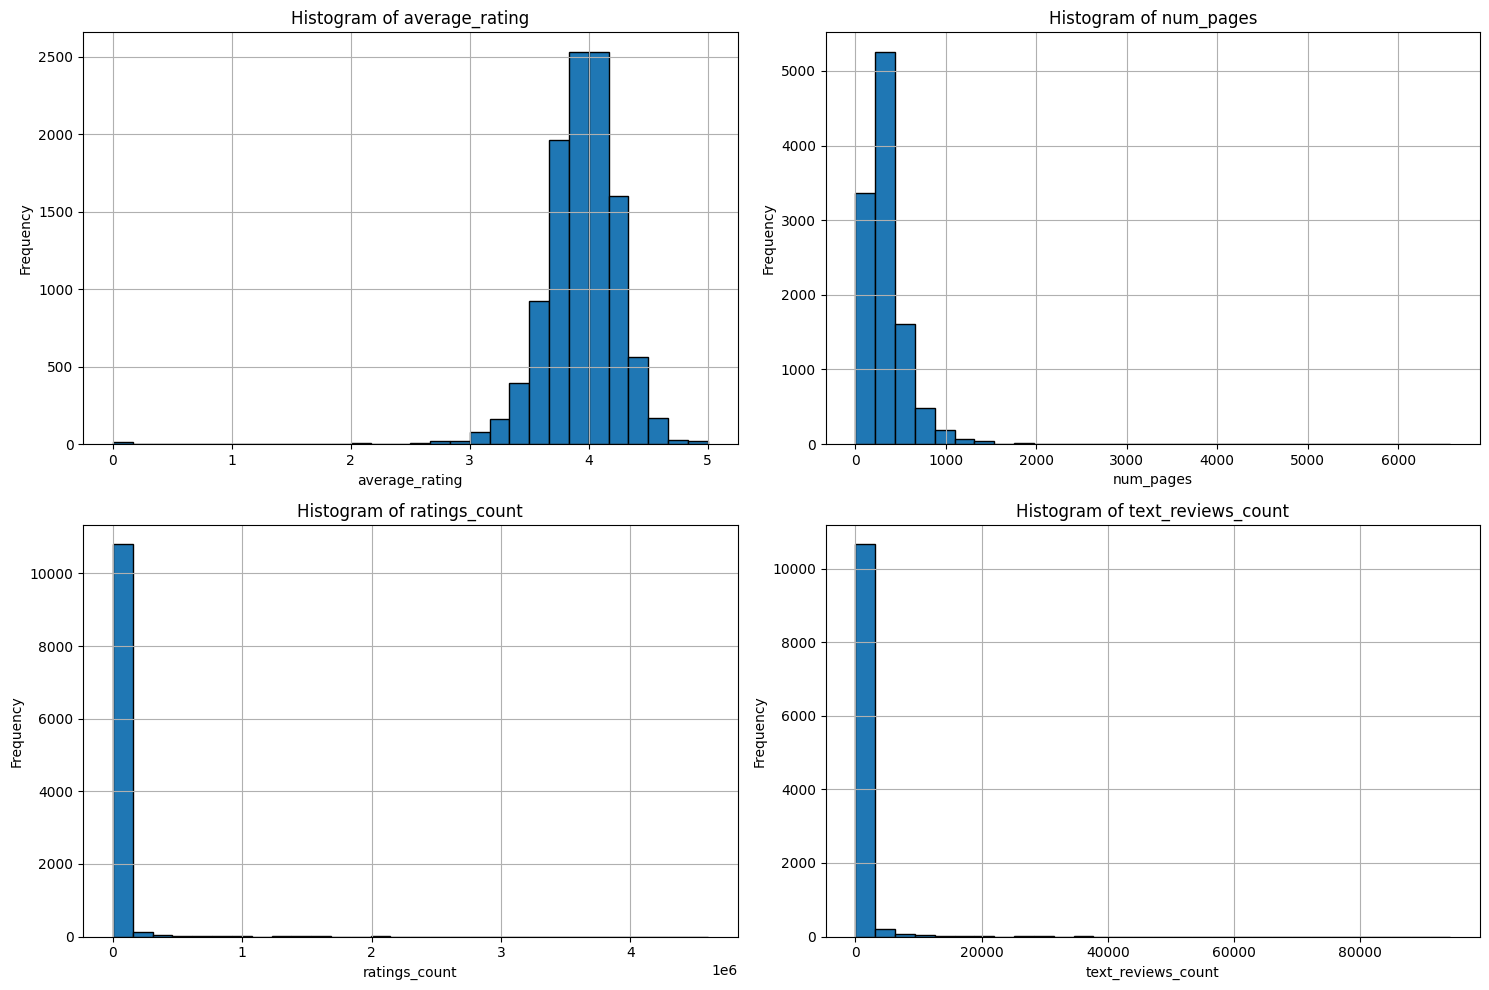

In [207]:
numerical_features = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 2, i+1)
    df[feature].hist(bins=30, edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#### View pair plot of numerical features
From the pair plot, we can see the following associations:
- average_rating is positively correlated with both ratings_count and text_reviews_count.
- num_pages is positively correlated with both ratings_count and text_reviews_count, but the correlation is not as strong as with average_rating.
- ratings_count and text_reviews_count have a very strong positive correlation.

<Figure size 1500x1000 with 0 Axes>

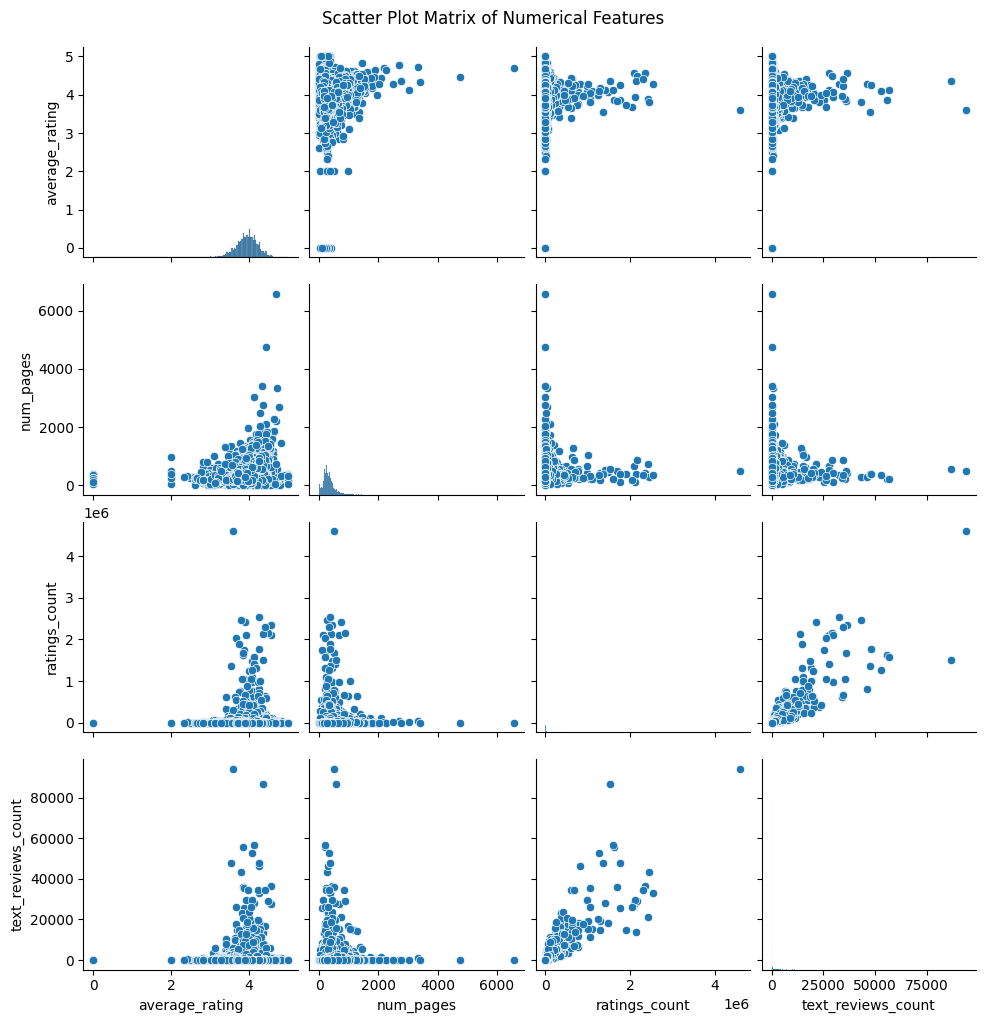

In [208]:
plt.figure(figsize=(15, 10))
sns.pairplot(df[numerical_features])
plt.suptitle('Scatter Plot Matrix of Numerical Features', y=1.02)
plt.show()

#### View a word cloud of all of the listed genres

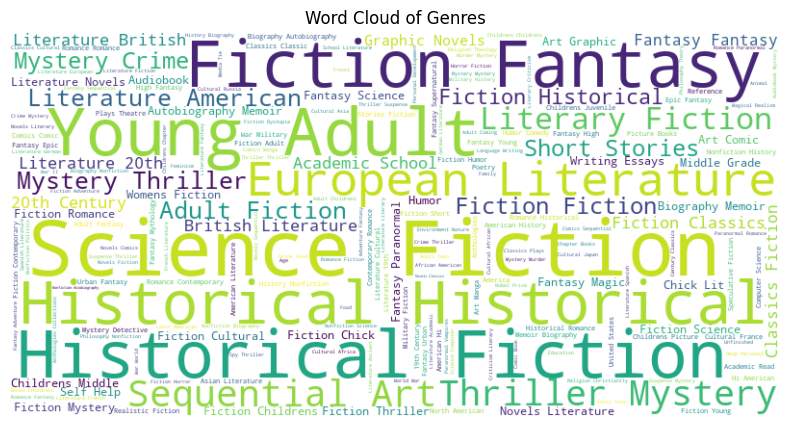

In [209]:
all_genres = ' '.join(df['genres'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

#### Remove irrelevant features
These features are not needed for our recommender due to general irrelavance and/or non-numerical nature

In [210]:
features = encoded_df.drop(['Book Id', 'Title', 'Author', 'isbn', 'isbn13', 'language_code', 'publication_date', 'publisher'], axis=1)

----
## Model Building
We will begin by using TruncatedSVD with Cosine Similarity and then explore and compare other models.

### Data preprocessing
#### Normalize selected features

In [211]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#### Create sparse matrix

In [212]:
features_sparse = csr_matrix(features_scaled)

### Hyperparameter Tuning

For the TruncatedSVD model, we want to use an n_components value that will balance accuracy and performance.

We will run a grid search and time each parameter to find the one that produces a high explained variance ratio at a decent speed.

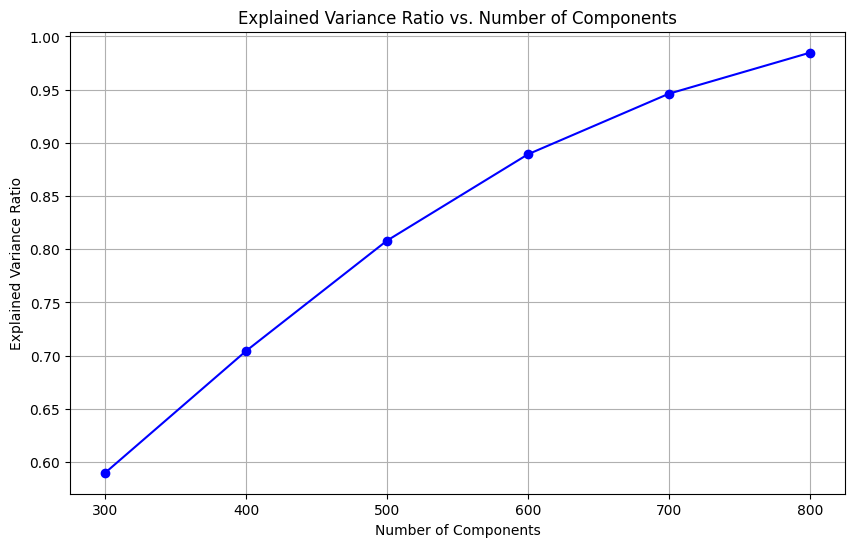

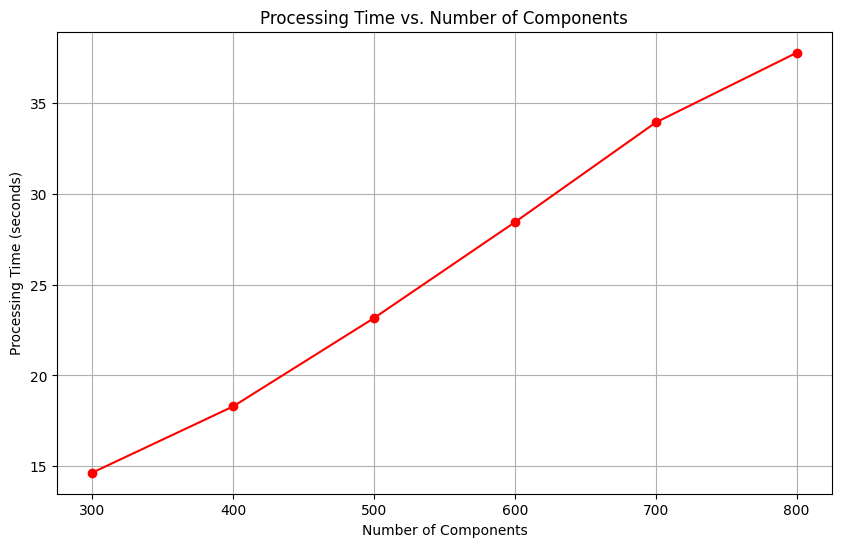

In [213]:
n_components_range = [300, 400, 500, 600, 700, 800]
best_n_components = 0
best_explained_variance = 0

explained_variance_scores = []
processing_times = []

for n_components in n_components_range:
    start_time = time.time()
    
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    svd.fit(features_sparse)
    explained_variance = svd.explained_variance_ratio_.sum()
    
    end_time = time.time()
    processing_time = end_time - start_time
    
    explained_variance_scores.append(explained_variance)
    processing_times.append(processing_time)

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, explained_variance_scores, marker='o', linestyle='-', color='b')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(n_components_range, processing_times, marker='o', linestyle='-', color='r')
plt.title('Processing Time vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Processing Time (seconds)')
plt.grid(True)
plt.show()


We can see that an n_component value of 500 yeilds a resonable score of ~80% at a time of ~24 seconds, so we will define this as the best paramter

In [214]:
best_n_component = 500

#### Dimensionality reduction

In [215]:
svd = TruncatedSVD(n_components=best_n_component, random_state=42)
features_reduced = svd.fit_transform(features_sparse)

#### Check how well the reduced features capture the variance in the original data

In [216]:
reconstructed_features = svd.inverse_transform(features_reduced)
original_features = features_sparse.toarray()

r2 = r2_score(original_features, reconstructed_features)
print(f'R-squared value: {r2}')

R-squared value: 0.808166824325285


#### Item-item similarity

In [217]:
similarity_matrix = cosine_similarity(features_reduced)

In [235]:
def recommend_books(book_id, num_recommendations=5):
    book_idx = encoded_df[encoded_df['Book Id'] == book_id].index[0]
    similarity_scores = similarity_matrix[book_idx]
    similar_books_indices = similarity_scores.argsort()[-(num_recommendations + 1):-1][::-1]
    return similar_books_indices

recommended_books = recommend_books(encoded_df['Book Id'].iloc[46], num_recommendations=5)
print("*"*20)
print("Recommended Books for:")
print("-"*20)
print(encoded_df['Title'].iloc[46])
print("="*20)
for i in recommended_books:
  print(encoded_df['Title'].iloc[i])
print("*"*20)

********************
Recommended Books for:
--------------------
The Control of Nature
Assembling California
Basin and Range
Rising from the Plains
The Control of Nature
A Crack in the Edge of the World
********************


### Evaluation

Measure the average similarity between items in the recommendation list

In [219]:
def intra_list_similarity(recommendations, similarity_matrix):
    similarities = []
    for i in range(len(recommendations)):
        for j in range(i + 1, len(recommendations)):
            similarities.append(similarity_matrix[recommendations[i], recommendations[j]])
    return np.mean(similarities)

ils = intra_list_similarity(recommended_books, similarity_matrix)
print(f'Intra-list Similarity: {ils}')

Intra-list Similarity: 0.9460351047299966


Measure the average dissimilarity between items in the recommendation list

In [220]:
def diversity(recommendations, similarity_matrix):
    dissimilarities = []
    for i in range(len(recommendations)):
        for j in range(i + 1, len(recommendations)):
            dissimilarities.append(1 - similarity_matrix[recommendations[i], recommendations[j]])
    return np.mean(dissimilarities)

div = diversity(recommended_books, similarity_matrix)
print(f'Diversity: {div}')

Diversity: 0.05396489527000339


These evaluation metrics show that the recommendations have a high similarity to the original book, with low diversity.

----
### Supervised Models

We can attempt to use supervised learning models to recommend books to the user, with Linear Regression, Random Forest, and Gradient Boosting

In [221]:
target = df['average_rating']
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

#### Linear Regression

In [222]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - R-squared: {r2_lr}')

Linear Regression - R-squared: 0.9757093515918038


#### Random Forest

In [223]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - R-squared: {r2_rf}')

Random Forest - R-squared: 0.9999841403677293


#### Gradient Boosting

In [224]:
from sklearn.ensemble import GradientBoostingRegressor

model_gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting - R-squared: {r2_gb}')

Gradient Boosting - R-squared: 0.9998995122880376


In [225]:
def supervised_recommend_books(input_book_id, encoded_df, features_scaled, pred_rating_label, num_recommendations=5):
    similarity_scores = calculate_similarity(input_book_id, features_scaled)
    encoded_df['SimilarityScore'] = similarity_scores
    similar_books = encoded_df[encoded_df['Book Id'] != input_book_id].nlargest(num_recommendations, 'SimilarityScore')
    return similar_books[['Title', 'Author', pred_rating_label, 'SimilarityScore']]

def calculate_similarity(input_book_id, features_scaled):
    input_book_idx = encoded_df[encoded_df['Book Id'] == input_book_id].index[0]
    input_book_features = features_scaled[input_book_idx].reshape(1, -1)
    
    similarity_scores = cosine_similarity(input_book_features, features_scaled)
    return similarity_scores.flatten()

In [236]:
predicted_ratings = model_lr.predict(features_scaled)
encoded_df['PredictedRating_LR'] = predicted_ratings

input_book_id = encoded_df['Book Id'].iloc[46]
similarity_scores = calculate_similarity(input_book_id, features_scaled)

lr_recommended_books = supervised_recommend_books(input_book_id, encoded_df, features_scaled, 'PredictedRating_LR')

print("*"*20)
print("Recommended Books for:")
print("-"*20)
print(encoded_df['Title'].iloc[46])
print("="*20)
for i in lr_recommended_books['Title']:
  print(i)


********************
Recommended Books for:
--------------------
The Control of Nature
Annals of the Former World
Assembling California
Basin and Range
Rising from the Plains
A Crack in the Edge of the World


In [238]:
predicted_ratings = model_rf.predict(features_scaled)
encoded_df['PredictedRating_RF'] = predicted_ratings

input_book_id = encoded_df['Book Id'].iloc[46]
similarity_scores = calculate_similarity(input_book_id, features_scaled)

rf_recommended_books = supervised_recommend_books(input_book_id, encoded_df, features_scaled, 'PredictedRating_RF')

print("*"*20)
print("Recommended Books for:")
print("-"*20)
print(encoded_df['Title'].iloc[46])
print("="*20)
for i in rf_recommended_books['Title']:
  print(i)


********************
Recommended Books for:
--------------------
The Control of Nature
Annals of the Former World
Assembling California
Basin and Range
Rising from the Plains
A Crack in the Edge of the World


In [237]:
predicted_ratings = model_gb.predict(features_scaled)
encoded_df['PredictedRating_GB'] = predicted_ratings

input_book_id = encoded_df['Book Id'].iloc[46]
similarity_scores = calculate_similarity(input_book_id, features_scaled)

rf_recommended_books = supervised_recommend_books(input_book_id, encoded_df, features_scaled, 'PredictedRating_GB')

print("*"*20)
print("Recommended Books for:")
print("-"*20)
print(encoded_df['Title'].iloc[46])
print("="*20)
for i in rf_recommended_books['Title']:
  print(i)


********************
Recommended Books for:
--------------------
The Control of Nature
Annals of the Former World
Assembling California
Basin and Range
Rising from the Plains
A Crack in the Edge of the World


## Conclusion
The R2 scores of the supervised models are exeptional and when we pair them with cosine similarity and build a recommender, they all perform equally as well as the TruncatedSVD model. Based on just the R2 scores, the unsupervised model did have a slightly lower score than the supervised collection and of the supervised models, Random Forest scored the highest.

It was difficult to evaluate the models with this dataset, given there was no ground truth data to be used. If we had some similarities that had been ground truthed, we could have compared the model's predictions to that and calculated a more precise evaluation.